In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import LeaveOneOutEncoder

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
data = "Data/nfl_stadiums.csv"
data2 = "Data/nfl_teams.csv"
data3 = "Data/spreadspoke_scores.csv"

dfstad = pd.read_csv(data, encoding="unicode_escape")
dfteam = pd.read_csv(data2)
dfscore = pd.read_csv(data3)

<IPython.core.display.Javascript object>

In [5]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12934 entries, 0 to 12933
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12934 non-null  object 
 1   schedule_season      12934 non-null  int64  
 2   schedule_week        12934 non-null  object 
 3   schedule_playoff     12934 non-null  bool   
 4   team_home            12934 non-null  object 
 5   score_home           12797 non-null  float64
 6   score_away           12797 non-null  float64
 7   team_away            12934 non-null  object 
 8   team_favorite_id     10318 non-null  object 
 9   spread_favorite      10318 non-null  float64
 10  over_under_line      10308 non-null  object 
 11  stadium              12934 non-null  object 
 12  stadium_neutral      12934 non-null  bool   
 13  weather_temperature  12008 non-null  float64
 14  weather_wind_mph     12008 non-null  float64
 15  weather_humidity     8388 non-null  

<IPython.core.display.Javascript object>

In [6]:
dfscore = dfscore.replace(r"^\s*$", np.nan, regex=True)
dfscore = dfscore.drop(
    columns=[
        "weather_humidity",
        "weather_detail",
        "weather_temperature",
        "weather_wind_mph",
        "schedule_date",
        "schedule_playoff",
        "stadium",
        "stadium_neutral",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
dfscore = dfscore[
    (dfscore["score_home"].isna() == False)
    & (dfscore["team_favorite_id"].isna() == False)
    & (dfscore["over_under_line"].isna() == False)
    & (dfscore["schedule_season"] >= 1979)
]

<IPython.core.display.Javascript object>

In [8]:
dfscore.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [9]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10234 entries, 0 to 10233
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   schedule_season   10234 non-null  int64  
 1   schedule_week     10234 non-null  object 
 2   team_home         10234 non-null  object 
 3   score_home        10234 non-null  float64
 4   score_away        10234 non-null  float64
 5   team_away         10234 non-null  object 
 6   team_favorite_id  10234 non-null  object 
 7   spread_favorite   10234 non-null  float64
 8   over_under_line   10234 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 719.7+ KB


<IPython.core.display.Javascript object>

In [10]:
home_scores = (
    dfscore[
        [
            "score_home",
            "schedule_season",
            "team_home",
        ]
    ]
    .groupby(["schedule_season", "team_home"])
    .mean()
    .reset_index()
)

away_scores = (
    dfscore[
        [
            "score_away",
            "schedule_season",
            "team_away",
        ]
    ]
    .groupby(["schedule_season", "team_away"])
    .mean()
    .reset_index()
)


dfscoreh = pd.merge(dfscore, home_scores, on=["team_home", "schedule_season"])

dfscoreb = pd.merge(dfscoreh, away_scores, on=["team_away", "schedule_season"])
dfscore = dfscoreb
dfscore["score_home"] = dfscore["score_home_x"]
dfscore["score_away"] = dfscore["score_away_x"]
dfscore["mean_home"] = dfscore["score_home_y"]
dfscore["mean_away"] = dfscore["score_away_y"]
dfscore = dfscore.drop(
    columns=["score_home_x", "score_away_x", "score_home_y", "score_away_y"]
)
dfscore.head()

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away
0,1979,1,Tampa Bay Buccaneers,Detroit Lions,TB,-3.0,30,31.0,16.0,17.875,10.875
1,1979,10,Chicago Bears,Detroit Lions,CHI,-7.0,35,35.0,7.0,22.375,10.875
2,1979,12,Minnesota Vikings,Detroit Lions,MIN,-4.0,37,14.0,7.0,18.875,10.875
3,1979,8,New Orleans Saints,Detroit Lions,NO,-7.0,42,17.0,7.0,21.500,10.875
4,1979,3,New York Jets,Detroit Lions,NYJ,-6.0,42,31.0,10.0,24.625,10.875


<IPython.core.display.Javascript object>

In [11]:
dfscore["over_under_line"] = dfscore["over_under_line"].astype(float)

<IPython.core.display.Javascript object>

In [12]:
dfscore["team_home"] = dfscore["team_home"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)
dfscore["team_away"] = dfscore["team_away"].map(
    dfteam.set_index("team_name")["team_id"].to_dict()
)

<IPython.core.display.Javascript object>

In [13]:
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_home"], "home_favorite"] = 1
dfscore.loc[dfscore["team_favorite_id"] == dfscore["team_away"], "away_favorite"] = 1
dfscore["home_favorite"].fillna(0, inplace=True)
dfscore["away_favorite"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [14]:
dfscore["score_dif"] = np.abs(dfscore["score_home"] - dfscore["score_away"])


<IPython.core.display.Javascript object>

In [15]:
dfscore.head(10)

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,mean_away,home_favorite,away_favorite,score_dif
0,1979,1,TB,DET,TB,-3.0,30.0,31.0,16.0,17.875,10.875,1.0,0.0,15.0
1,1979,10,CHI,DET,CHI,-7.0,35.0,35.0,7.0,22.375,10.875,1.0,0.0,28.0
2,1979,12,MIN,DET,MIN,-4.0,37.0,14.0,7.0,18.875,10.875,1.0,0.0,7.0
3,1979,8,NO,DET,NO,-7.0,42.0,17.0,7.0,21.500,10.875,1.0,0.0,10.0
4,1979,3,NYJ,DET,NYJ,-6.0,42.0,31.0,10.0,24.625,10.875,1.0,0.0,21.0
5,1979,14,PHI,DET,PHI,-8.0,37.0,44.0,7.0,21.750,10.875,1.0,0.0,37.0
6,1979,6,NE,DET,NE,-13.0,40.0,24.0,17.0,29.750,10.875,1.0,0.0,7.0
7,1979,7,GB,DET,GB,-4.0,36.0,24.0,16.0,19.250,10.875,1.0,0.0,8.0
8,1979,4,TB,LAR,LAR,-3.0,35.0,21.0,6.0,17.875,20.875,0.0,1.0,15.0
9,1979,11,CHI,LAR,PICK,0.0,34.0,27.0,23.0,22.375,20.875,0.0,0.0,4.0


<IPython.core.display.Javascript object>

In [16]:
dfscore.loc[
    ((dfscore["score_home"] + dfscore["score_away"]) > dfscore["over_under_line"]),
    "is_over",
] = 1
dfscore["is_over"].fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [17]:
# pd.crosstab(dfscore["team_away"], dfscore["is_over"])

<IPython.core.display.Javascript object>

In [18]:
# dfscore["total_pts"] = dfscore["score_home"] + dfscore["score_away"]

<IPython.core.display.Javascript object>

In [19]:
dfscore_copy = dfscore.copy()

<IPython.core.display.Javascript object>

In [20]:
# Create features to show if favorited team makes spread or simply wins ml. 
dfscore["away_w_fav"] = 0
dfscore["home_w_fav"] = 0
dfscore["away_ml_fav"] = 0
dfscore["home_ml_fav"] = 0


dfscore.loc[
    (
        (
            dfscore["score_away"] - dfscore["score_home"]
            > np.abs(dfscore["spread_favorite"])
        )
        & (dfscore["away_favorite"] == 1)
    ),
    "away_w_fav",
] = 1

dfscore.loc[
    (
        (
            dfscore["score_away"] > dfscore["score_home"]
        )
        & (dfscore["away_favorite"] == 1)
    ),
    "away_ml_fav",
] = 1



dfscore.loc[
    (
        (
            dfscore["score_home"] - dfscore["score_away"]
            > np.abs(dfscore["spread_favorite"])
        )
        & (dfscore["home_favorite"] == 1)
    ),
    "home_w_fav",
] = 1

dfscore.loc[
    (
        (
            dfscore["score_home"] > dfscore["score_away"]
        )
        & (dfscore["home_favorite"] == 1)
    ),
    "home_ml_fav",
] = 1



<IPython.core.display.Javascript object>

In [21]:
# looking  at statistics of how often the favored team team wins or covers a spread.
# Home win (~68%), covers (~47%)
# Away win (~62%), covers (~47%)

#display(dfscore[dfscore["away_favorite"] == 1].describe().transpose())
#dfscore[dfscore["home_favorite"] == 1].describe().transpose()


<IPython.core.display.Javascript object>

In [22]:
# sns.pairplot(dfscore)

<IPython.core.display.Javascript object>

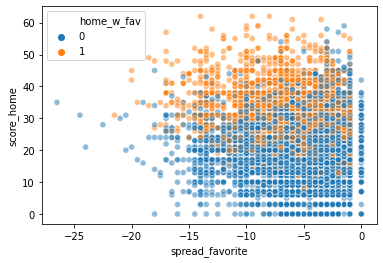

<IPython.core.display.Javascript object>

In [23]:
sns.scatterplot(
    x="spread_favorite", y="score_home", hue="home_w_fav", alpha=0.5, data=dfscore
)
plt.show()



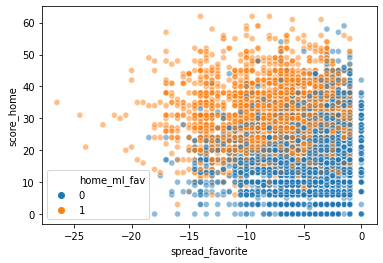

<IPython.core.display.Javascript object>

In [24]:
sns.scatterplot(
    x="spread_favorite", y="score_home", hue="home_ml_fav", alpha=0.5, data=dfscore
)
plt.show()

In [25]:
# dfscore.loc(dfscore["home_favorite"] == 1)

<IPython.core.display.Javascript object>

In [26]:
dfscore.loc[(dfscore.schedule_week == "18"), "schedule_week"] = "17"
dfscore.loc[
    (dfscore.schedule_week == "Wildcard") | (dfscore.schedule_week == "WildCard"),
    "schedule_week",
] = "18"
dfscore.loc[(dfscore.schedule_week == "Division"), "schedule_week"] = "19"
dfscore.loc[(dfscore.schedule_week == "Conference"), "schedule_week"] = "20"
dfscore.loc[
    (dfscore.schedule_week == "Superbowl") | (dfscore.schedule_week == "SuperBowl"),
    "schedule_week",
] = "21"
dfscore["schedule_week"] = dfscore.schedule_week.astype(int)

<IPython.core.display.Javascript object>

In [27]:
dfscore["schedule_week"]

0         1
1        10
2        12
3         8
4         3
         ..
10229     5
10230     2
10231     7
10232     5
10233     4
Name: schedule_week, Length: 10234, dtype: int64

<IPython.core.display.Javascript object>

In [28]:
dfss = dfscore[(dfscore["schedule_week"] >= 3) & (dfscore["schedule_week"] <= 15)]


<IPython.core.display.Javascript object>

In [29]:
# Need to add other columns to lag...
# Then need to refactor
home_lag_df = dfscore[
    [
        "schedule_season",
        "schedule_week",
        "team_home",
        "score_home",
        "home_w_fav",
        "home_ml_fav",
    ]
]
home_lag_df = home_lag_df.rename(
    columns={
        "team_home": "team",
        "score_home": "score",
        "home_w_fav": "w_fav",
        "home_ml_fav": "ml_fav",
    }
)
away_lag_df = dfscore[
    [
        "schedule_season",
        "schedule_week",
        "team_away",
        "score_away",
        "away_w_fav",
        "away_ml_fav",
    ]
]
away_lag_df = away_lag_df.rename(
    columns={
        "team_away": "team",
        "score_away": "score",
        "away_w_fav": "w_fav",
        "away_ml_fav": "ml_fav",
    }
)
lag_df = pd.concat((away_lag_df, home_lag_df))
lag_df = lag_df.sort_values(["schedule_season", "team", "schedule_week"])


# Create lag variables for a team's prior 2 game scores
# create new shifts for new columns
lag_df["score_lag_1"] = lag_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=1
)
lag_df["score_lag_2"] = lag_df.groupby(["schedule_season", "team"])["score"].shift(
    periods=2
)

lag_df["spread_lag_1"] = lag_df.groupby(["schedule_season", "team"])["w_fav"].shift(
    periods=1
)
lag_df["spread_lag_2"] = lag_df.groupby(["schedule_season", "team"])["w_fav"].shift(
    periods=2
)

lag_df["ml_lag_1"] = lag_df.groupby(["schedule_season", "team"])["ml_fav"].shift(
    periods=1
)
lag_df["ml_lag_2"] = lag_df.groupby(["schedule_season", "team"])["ml_fav"].shift(
    periods=2
)

lag_df.head()

,schedule_season,schedule_week,team,score,w_fav,ml_fav,score_lag_1,score_lag_2,spread_lag_1,spread_lag_2,ml_lag_1,ml_lag_2
187,1979,1,ARI,21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
124,1979,2,ARI,27.0,1,1,21.0,NaN,0.0,NaN,0.0,NaN
163,1979,3,ARI,21.0,0,0,27.0,21.0,1.0,0.0,1.0,0.0
210,1979,4,ARI,7.0,0,0,21.0,27.0,0.0,1.0,0.0,1.0
121,1979,5,ARI,0.0,0,0,7.0,21.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [30]:
# Add new columns for home away merges
dfssm = pd.merge(dfss, lag_df, left_on=['schedule_season','schedule_week','team_home'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'home_sl_1', 'score_lag_2':'home_sl_2', 'spread_lag_1': 'h_sprl_1',
                               'spread_lag_2': 'h_sprl_2', 
                               'ml_lag_1': 'h_mll_1',
                               'ml_lag_2': 'h_mll_2'})
dfssm = dfssm.drop(columns= ['score','team', 'w_fav', 'ml_fav'])

dfssm = pd.merge(dfssm, lag_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])
dfssm = dfssm.rename(columns = {'score_lag_1': 'away_sl_1', 'score_lag_2':'away_sl_2',
                                'spread_lag_1': 'a_sprl_1',
                               'spread_lag_2': 'a_sprl_2', 
                               'ml_lag_1': 'a_mll_1',
                               'ml_lag_2': 'a_mll_2'})
dfssm = dfssm.drop(columns= ['score','team', 'w_fav', 'ml_fav'])

#dfss = pd.merge(dfssm, score_df, left_on=['schedule_season','schedule_week','team_away'], right_on=['schedule_season', 'schedule_week','team'])


<IPython.core.display.Javascript object>

In [31]:
dfss = dfssm.dropna()
dfss.isna().sum()

schedule_season     0
schedule_week       0
team_home           0
team_away           0
team_favorite_id    0
spread_favorite     0
over_under_line     0
score_home          0
score_away          0
mean_home           0
mean_away           0
home_favorite       0
away_favorite       0
score_dif           0
is_over             0
away_w_fav          0
home_w_fav          0
away_ml_fav         0
home_ml_fav         0
home_sl_1           0
home_sl_2           0
h_sprl_1            0
h_sprl_2            0
h_mll_1             0
h_mll_2             0
away_sl_1           0
away_sl_2           0
a_sprl_1            0
a_sprl_2            0
a_mll_1             0
a_mll_2             0
dtype: int64

<IPython.core.display.Javascript object>

In [32]:
dfss[dfss["schedule_season"] == 2018].sort_values(by="schedule_week").head(20)

,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,score_home,score_away,mean_home,...,h_sprl_1,h_sprl_2,h_mll_1,h_mll_2,away_sl_1,away_sl_2,a_sprl_1,a_sprl_2,a_mll_1,a_mll_2
7134,2018,3,TB,PIT,PIT,-1.0,55.0,27.0,30.0,22.500000,...,0.0,0.0,0.0,0.0,37.0,21.0,0.0,0.0,0.0,0.0
7073,2018,3,ARI,CHI,CHI,-5.5,39.0,14.0,16.0,12.250000,...,0.0,0.0,0.0,0.0,24.0,23.0,1.0,0.0,1.0,0.0
7197,2018,3,JAX,TEN,JAX,-10.0,39.0,6.0,9.0,16.000000,...,0.0,1.0,0.0,1.0,20.0,20.0,0.0,0.0,0.0,0.0
7200,2018,3,DET,NE,NE,-7.0,55.0,26.0,10.0,18.625000,...,0.0,0.0,0.0,0.0,20.0,27.0,0.0,1.0,0.0,1.0
7085,2018,3,BAL,DEN,BAL,-5.5,46.0,27.0,14.0,26.000000,...,0.0,1.0,0.0,1.0,20.0,27.0,0.0,0.0,1.0,1.0
7164,2018,3,CLE,NYJ,CLE,-3.0,41.0,21.0,17.0,21.125000,...,0.0,0.0,0.0,0.0,12.0,48.0,0.0,0.0,0.0,0.0
7095,2018,3,KC,SF,KC,-5.5,53.0,38.0,27.0,32.100000,...,0.0,0.0,0.0,0.0,30.0,16.0,0.0,0.0,1.0,0.0
7061,2018,3,HOU,NYG,HOU,-6.5,44.0,22.0,27.0,23.777778,...,0.0,0.0,0.0,0.0,13.0,15.0,0.0,0.0,0.0,0.0
7100,2018,3,MIA,LVR,MIA,-3.0,46.0,28.0,20.0,22.750000,...,0.0,0.0,0.0,0.0,19.0,13.0,0.0,0.0,0.0,0.0
7154,2018,3,LAR,LAC,LAR,-7.5,49.0,35.0,23.0,33.000000,...,1.0,1.0,1.0,1.0,31.0,28.0,1.0,0.0,1.0,0.0


<IPython.core.display.Javascript object>

In [33]:
dfss.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
schedule_season,7484.0,1999.934527,11.905930,1979.000,1990.000,2000.000,2010.0000,2020.000000
schedule_week,7484.0,9.150588,3.773865,3.000,6.000,9.000,12.0000,15.000000
spread_favorite,7484.0,-5.378608,3.462268,-26.500,-7.000,-4.500,-3.0000,0.000000
over_under_line,7484.0,42.049599,4.689510,30.000,38.500,42.000,45.0000,63.500000
score_home,7484.0,22.609166,10.336124,0.000,16.000,22.000,30.0000,62.000000
score_away,7484.0,20.101817,10.044897,0.000,13.000,20.000,27.0000,59.000000
mean_home,7484.0,22.522542,4.942632,8.750,19.125,22.375,25.6875,41.555556
mean_away,7484.0,19.902455,4.751042,5.125,16.750,19.625,22.8750,39.250000
home_favorite,7484.0,0.660609,0.473534,0.000,0.000,1.000,1.0000,1.000000
away_favorite,7484.0,0.325227,0.468491,0.000,0.000,0.000,1.0000,1.000000


<IPython.core.display.Javascript object>

In [34]:
# dfss.corr().style.background_gradient()

<IPython.core.display.Javascript object>

In [35]:
# corelation heatmap

# plt.figure(figsize=(20, 15))
# sns.heatmap(dfss.corr(), vmin=-1, vmax=1, annot=True)
# plt.show()

<IPython.core.display.Javascript object>

In [36]:
print(dfss.columns)

Index(['schedule_season', 'schedule_week', 'team_home', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'score_home',
       'score_away', 'mean_home', 'mean_away', 'home_favorite',
       'away_favorite', 'score_dif', 'is_over', 'away_w_fav', 'home_w_fav',
       'away_ml_fav', 'home_ml_fav', 'home_sl_1', 'home_sl_2', 'h_sprl_1',
       'h_sprl_2', 'h_mll_1', 'h_mll_2', 'away_sl_1', 'away_sl_2', 'a_sprl_1',
       'a_sprl_2', 'a_mll_1', 'a_mll_2'],
      dtype='object')


<IPython.core.display.Javascript object>

### Modeling 

In [37]:
# This model outcome was inferior, decided to switch to ML predictions. commenting out workflow.
# X = dfss.drop(
#    columns=[
#        "schedule_season",
#        #'schedule_week',
#        #'team_home',
#        #'team_away',
#        #'team_favorite_id',
#        #'spread_favorite',
#        #'over_under_line',
#        "score_home",
#        "score_away",
#        #'mean_home',
#        #'mean_away',
#        "home_favorite",
#        #'away_favorite',
#        #'score_dif',
#        "is_over",
#        #'away_w_fav',
#        #'home_w_fav',
#        #'away_ml_fav',
#        #'home_ml_fav',
#        #'home_sl_1',
#        #'home_sl_2',
#        #'h_sprl_1',
#        #'h_sprl_2',
#        #'h_mll_1',
#        #'h_mll_2',
#        #'away_sl_1',
#        #'away_sl_2',
#        #'a_sprl_1',
#        #'a_sprl_2',
#        #'a_mll_1',
#        #'a_mll_2'
#    ]
# )
# y = dfss["is_over"]
#
# X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42
# )

<IPython.core.display.Javascript object>

In [38]:
# This is code to visualize relationships between features.

# encoded = LeaveOneOutEncoder().fit_transform(X_train, y_train)
## df_train = pd.concat((encoded, y_train), axis=1)
## sns.pairplot(df_train[["score_home", "score_away", "is_over"]], hue="is_over")
## plt.show()
## tall_df_train = df_train.melt(id_vars="is_over")
## fg = sns.FacetGrid(tall_df_train, col="variable", col_wrap=4)
## fg.map(sns.boxplot, "is_over", "value")
## plt.show()
# display(encoded.head())
#

<IPython.core.display.Javascript object>

In [39]:
# bin_cols = [
#    "is_over",
#    # "home_favorite",
#    "away_favorite",
#    "away_w_fav",
#    "home_w_fav",
#    "away_ml_fav",
#    "home_ml_fav",
#    "h_sprl_1",
#    "h_sprl_2",
#    "h_mll_1",
#    "h_mll_2",
#    "a_sprl_1",
#    "a_sprl_2",
#    "a_mll_1",
#    "a_mll_2",
# ]
# num_cols = [
#    "mean_home",
#    "mean_away",
#    "spread_favorite",
#    "over_under_line",
#    "home_sl_1",
#    "home_sl_2",
#    "away_sl_1",
#    "away_sl_2",
#    "score_dif",
# ]
# cat_cols = [
#    "schedule_week",
#    "team_home",
#    "team_away",
#    "team_favorite_id",
# ]
#
# prep = ColumnTransformer(
#    [
#        ("leave_one", LeaveOneOutEncoder(), cat_cols),
#    ],
#    remainder="passthrough",
# )

<IPython.core.display.Javascript object>

In [40]:
# prep.fit_transform(X_train, y_train)[3, :]

<IPython.core.display.Javascript object>

In [41]:
# transformed = prep.fit_transform(X_train, y_train)
## ToDO get printVIF and run it.
# type(transformed)
## ToD0, create dataframe with transformed.
# transformed = pd.DataFrame(transformed, columns=X_train.columns)
# print_vif(transformed)

<IPython.core.display.Javascript object>

In [42]:
# plt.figure(figsize=(20, 15))
# sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
# plt.show()

<IPython.core.display.Javascript object>

In [43]:
# Try SVC
# pipe = Pipeline([("prep", prep), ("svc", SVC())])
#
# grid = {
#    "svc__kernel": ["linear", "poly", "rbf"],
#    "svc__degree": [2, 3, 4],
#    "svc__C": [0.001, 0.01, 0.1, 1],
# }
#
# pipe_cv = GridSearchCV(pipe, grid, cv=3, n_jobs=-1)

<IPython.core.display.Javascript object>

### Fit and Eval

In [44]:
# pipe_cv.fit(X_train, y_train)
#
# print("Best params:")
# print(pipe_cv.best_params_)
#
# print(f"\ntrain score: {pipe_cv.score(X_train,y_train):.3f}")
# print(f"test score: {pipe_cv.score(X_test, y_test):.3f}\n")
#
# y_pred = pipe_cv.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

<IPython.core.display.Javascript object>

### Feature Importance 

In [45]:
# Turn back on if switches back to linear
# coef = pipe_cv.best_estimator_["svc"].coef_[0]
# im_df = pd.DataFrame({"feature": X_train.columns, "coef_sq": coef ** 2})
# im_df.sort_values("coef_sq", ascending=False)

<IPython.core.display.Javascript object>

In [46]:
# Look at XTrain, and see what can trim without losing accuracy.
# X_train.head()

<IPython.core.display.Javascript object>

### Error Analysis

In [47]:
# errors = dfscore_copy.copy()
# errors = errors.loc[y_test.index]
#
# errors["y_true"] = y_test
# errors["y_pred"] = y_pred
#
# errors = errors[errors["y_true"] != errors["y_pred"]]
#
# print(f'mean prob of over for errors: {errors["is_over"].mean()}')


# sns.swarmplot(y=errors["is_over"])
# plt.show()
# predict_proba(y_test)

<IPython.core.display.Javascript object>

### Try XGBoost

In [48]:
# n_trees = 100
## learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)
#
# x_pipe = Pipeline(
#    [
#        ("prep", prep),
#        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
#    ]
# )
#
# x_grid = {
#    "xgb__subsample": [0.5, 0.75, 1],
#    "xgb__colsample_bytree": [0.5, 0.75, 1],
#    "xgb__max_depth": [2, 3, 4, 5],
# }
#
# x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=4, n_jobs=-1)

<IPython.core.display.Javascript object>

In [49]:
# x_pipe_cv.fit(X_train, y_train)
#
# print("Best params:")
# print(x_pipe_cv.best_params_)
#
# print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
# print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")
#
# y_predx = x_pipe_cv.predict(X_test)
# print(confusion_matrix(y_test, y_predx))
# print(classification_report(y_test, y_predx))

<IPython.core.display.Javascript object>

In [50]:
# importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
# im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
# im_df.sort_values("importance", ascending=False)

<IPython.core.display.Javascript object>

In [51]:
# errors = dfscore_copy.copy()
# errors = errors.loc[y_test.index]
#
# errors["y_true"] = y_test
# errors["y_pred"] = y_predx
#
# errors = errors[errors["y_true"] != errors["y_pred"]]
#
# print(f'mean prob of over for errors: {errors["is_over"].mean()}')
#
#
# sns.swarmplot(y=errors["is_over"])
# plt.show()

<IPython.core.display.Javascript object>

## Rearrange the model for betting favorite

In [52]:
# Remove columns if they are items that have colinearity or are too informative. i.e. post game stats for the current week prediction.

# Run the model with the below 4 columns to see if we can keep around a 79% accuracy score.
# 8	away_favorite	0.668321
# 6	mean_home	0.064701
# 4	spread_favorite	0.047757
# 7	mean_away	0.040029
X = dfss.drop(
    columns=[
        "schedule_season",
        "schedule_week",
        "team_home",
        "team_away",
        "team_favorite_id",
        #'spread_favorite',
        "over_under_line",
        "score_home",
        "score_away",
        # "mean_home",
        # "mean_away",
        # "home_favorite",
        "away_favorite",
        "score_dif",
        "is_over",
        "away_w_fav",
        "home_w_fav",
        "away_ml_fav",
        "home_ml_fav",
        "home_sl_1",
        "home_sl_2",
        "h_sprl_1",
        "h_sprl_2",
        "h_mll_1",
        "h_mll_2",
        "away_sl_1",
        "away_sl_2",
        "a_sprl_1",
        "a_sprl_2",
        "a_mll_1",
        "a_mll_2",
    ]
)
y = dfss["home_ml_fav"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [53]:
X.columns

Index(['spread_favorite', 'mean_home', 'mean_away', 'home_favorite'], dtype='object')

<IPython.core.display.Javascript object>

In [54]:
bin_cols = [
    # "is_over",
    "home_favorite",
    # "away_favorite",
    # "away_w_fav",
    # "home_w_fav",
    # "away_ml_fav",
    # "home_ml_fav",
    # "h_sprl_1",
    # "h_sprl_2",
    # "h_mll_1",
    # "h_mll_2",
    # "a_sprl_1",
    # "a_sprl_2",
    # "a_mll_1",
    # "a_mll_2",
]
num_cols = [
    "spread_favorite",
    "mean_home",
    "mean_away",
    # "over_under_line",
    # "home_sl_1",
    # "home_sl_2",
    # "away_sl_1",
    # "away_sl_2",
    # "score_dif",
]
cat_cols = [
    # "schedule_week",
    # "team_home",
    # "team_away",
    # "team_favorite_id",
]

prep = ColumnTransformer(
    [
        ("leave_one", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [55]:
transformed = prep.fit_transform(X_train, y_train)
# ToDO get printVIF and run it.
type(transformed)
# ToD0, create dataframe with transformed.
transformed = pd.DataFrame(transformed, columns=X_train.columns)
print_vif(transformed)

VIF results
-------------------------------
const              41.997693
spread_favorite     1.110624
mean_home           1.217519
mean_away           1.203789
home_favorite       1.339205
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

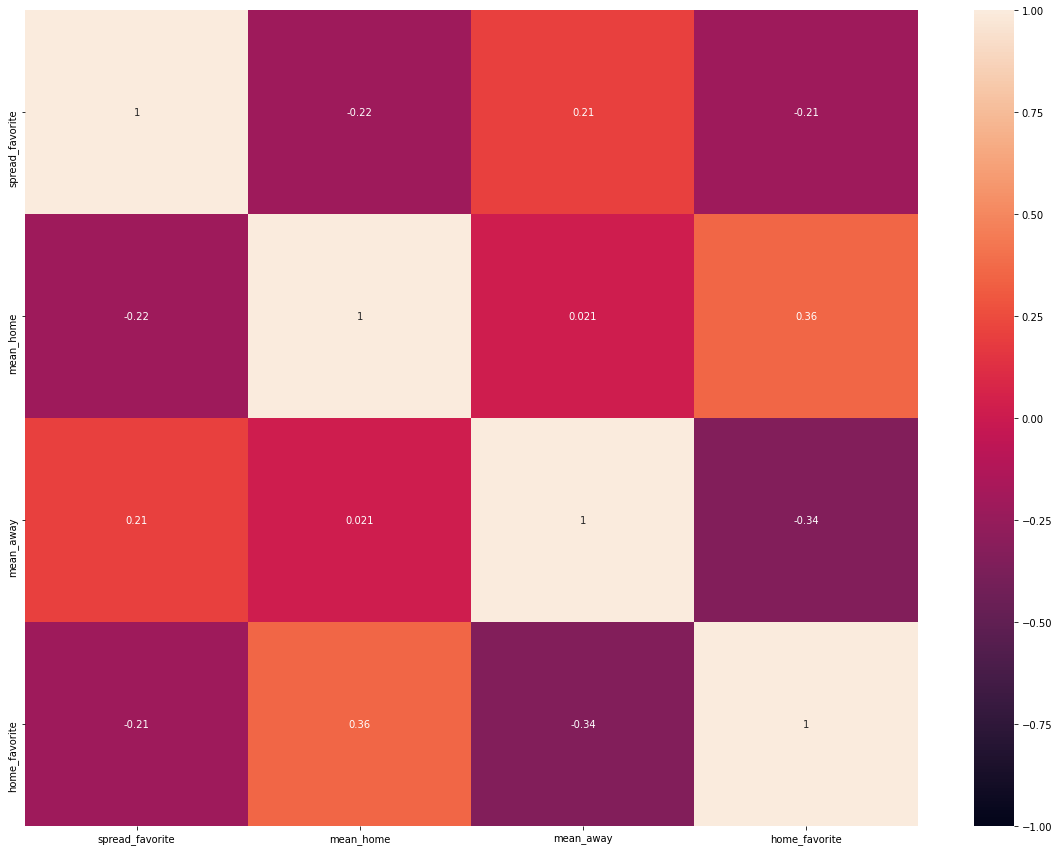

<IPython.core.display.Javascript object>

In [56]:
# Looking for correlations over .5 -- There is only one, and that is ok.
plt.figure(figsize=(20, 15))
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [57]:
n_trees = 100
# learning_rate = ([0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],)

x_pipe = Pipeline(
    [
        ("prep", prep),
        ("xgb", XGBClassifier(n_estimators=n_trees, learning_rate=0.01 / n_trees)),
    ]
)

x_grid = {
    "xgb__subsample": [0.5, 0.75, 1],
    "xgb__colsample_bytree": [0.5, 0.75, 1],
    "xgb__max_depth": [2, 3, 4, 5],
}

x_pipe_cv = GridSearchCV(x_pipe, x_grid, cv=4, n_jobs=-1)

<IPython.core.display.Javascript object>

In [58]:
x_pipe_cv.fit(X_train, y_train)

print("Best params:")
print(x_pipe_cv.best_params_)

print(f"\ntrain score: {x_pipe_cv.score(X_train, y_train):.3f}")
print(f"test score: {x_pipe_cv.score(X_test, y_test):.3f}\n")

y_predx = x_pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_predx))
print(classification_report(y_test, y_predx))

[10:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__subsample': 0.75}

train score: 0.815
test score: 0.799

[[595 249]
 [ 52 601]]
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       844
           1       0.71      0.92      0.80       653

    accuracy                           0.80      1497
   macro avg       0.81      0.81      0.80      1497
weighted avg       0.83      0.80      0.80      1497



/Users/JasonB/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<IPython.core.display.Javascript object>

In [59]:
# Un nest XGB then run predict proba to get probaility score ideas
pred_prob_0 = x_pipe_cv.best_estimator_["xgb"].predict_proba(X_test)[:, 0]

<IPython.core.display.Javascript object>

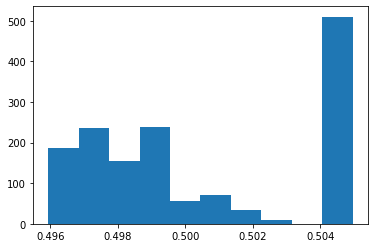

<IPython.core.display.Javascript object>

In [60]:
# Visualize confidence of model.
plt.hist(pred_prob_0)
plt.show()

In [61]:
importances = x_pipe_cv.best_estimator_["xgb"].feature_importances_
im_df = pd.DataFrame({"features": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,features,importance
3,home_favorite,0.968278
1,mean_home,0.014941
2,mean_away,0.011529
0,spread_favorite,0.005251


<IPython.core.display.Javascript object>

In [71]:
# errors = dfscore_copy.copy()
# errors = errors.loc[y_test.index]
#
# errors["y_true"] = y_test
# errors["y_pred"] = y_predx
#
# errors = errors[errors["y_true"] != errors["y_pred"]]
#
# print(f'mean prob of ml win for errors: {errors["ml_fav"].mean()}')
#
#
# sns.swarmplot(y=errors["ml_fav"])
# plt.show()

<IPython.core.display.Javascript object>

## Try SVM on Money Line outcome for favorited team

In [64]:
pipe = Pipeline([("prep", prep), ("svc", SVC(probability=True))])

grid = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2, 3, 4],
    "svc__C": [0.001, 0.01, 0.1, 1],
}

pipe_cv = GridSearchCV(pipe, grid, cv=2, n_jobs=-1)

<IPython.core.display.Javascript object>

In [65]:
pipe_cv.fit(X_train, y_train)

print("Best params:")
print(pipe_cv.best_params_)

print(f"\ntrain score: {pipe_cv.score(X_train,y_train):.3f}")
print(f"test score: {pipe_cv.score(X_test, y_test):.3f}\n")

y_pred = pipe_cv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 1, 'svc__degree': 3, 'svc__kernel': 'poly'}

train score: 0.801
test score: 0.793

[[562 282]
 [ 28 625]]
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       844
           1       0.69      0.96      0.80       653

    accuracy                           0.79      1497
   macro avg       0.82      0.81      0.79      1497
weighted avg       0.84      0.79      0.79      1497



<IPython.core.display.Javascript object>

In [66]:
# Calibration Curve is best to look at probability of 1.  As it will keep skew from happening.
x_pred_prob_1 = x_pipe_cv.best_estimator_["xgb"].predict_proba(X_test)[:, 1]
pred_prob_1 = pipe_cv.best_estimator_["svc"].predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

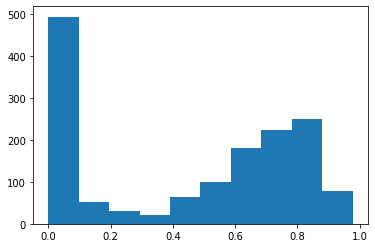

<IPython.core.display.Javascript object>

In [67]:
plt.hist(pred_prob_1)
plt.show()

In [68]:
from sklearn.calibration import calibration_curve

# This only cares about positive class (1).
# In a multi class scenarioe, run multiple times for each class.
prob_true, prob_pred = calibration_curve(y_test, pred_prob_1)
x_prob_true, x_prob_pred = calibration_curve(y_test, x_pred_prob_1)

<IPython.core.display.Javascript object>

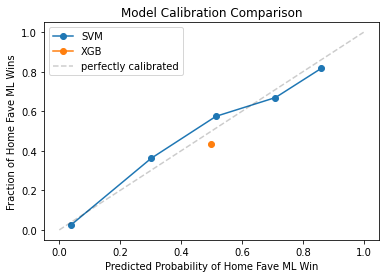

<IPython.core.display.Javascript object>

In [69]:
plt.plot(prob_pred, prob_true, "-o", label="SVM")
plt.plot(x_prob_pred, x_prob_true, "-o", label="XGB")
plt.plot([0, 1], [0, 1], "--", label="perfectly calibrated", c="black", alpha=0.2)
plt.title("Model Calibration Comparison")
plt.xlabel("Predicted Probability of Home Fave ML Win")
plt.ylabel("Fraction of Home Fave ML Wins")
plt.legend()
plt.show()
# below line, means more confident and less accurate.
#

In [ ]:
# coef = pipe_cv.best_estimator_["svc"].coef_[0]
# im_df = pd.DataFrame({"feature": X_train.columns, "coef_sq": coef ** 2})
# im_df.sort_values("coef_sq", ascending=False)

In [75]:
errors = dfscore_copy.copy()
errors = errors.loc[y_test.index]

errors["y_true"] = y_test
errors["y_pred"] = y_pred

errors = errors[errors["y_true"] != errors["y_pred"]]

print(f'Mean prob of "home team ML win" for errors: {errors["is_over"].mean()}')


# sns.swarmplot(y=errors["is_over"])
# plt.show()
# predict_proba(y_test)

Mean prob of "home team ML win" for errors: 0.43548387096774194


<IPython.core.display.Javascript object>

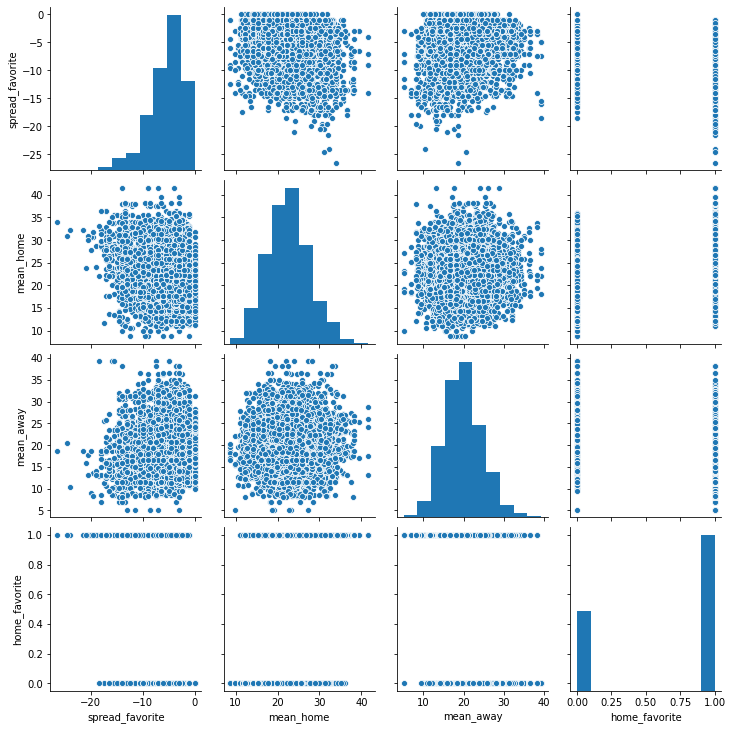

<IPython.core.display.Javascript object>

In [76]:
sns.pairplot(X)
plt.show()

In [ ]:
((-250 / 150) * (-510 / 410) * (220 / 120))

In [ ]:
thresh_df = pd.DataFrame({"actual": y_test, "pred_prob": pred_prob_1, "pred": y_pred})
# Set threshholds of trust, and look at how often correct.
bet_w = thresh_df[thresh_df["pred_prob"] > 0.84]
display((bet_w["actual"] == bet_w["pred"]).mean())

bet_l = thresh_df[thresh_df["pred_prob"] < 0.16]
(bet_l["actual"] == bet_l["pred"]).mean()

In [ ]:
0.85 ** 4

Parlay typical odds - 2 games: 2.6/1, 3 games: 6/1, 4 games : 

First, we have to determine what the multipliers would be for each game, simply divide what the total payout would be (risk + win) by the risk amount

Giants - 150 to win 100, so the total payout would be $250
250/150 = 1.6666

Dolphins - 100 to win 170, so the total payout would be $270
270/100 = 2.7

Rangers - 120 to win 100, so the total payout would be $220
220/120 = 1.8333

Now that we have the multipliers, we multiply them together to come up with the True odds of the parlay.
1.6666 x 2.7 x 1.8333 = 8.2495

The return on your parlay would be about 8.25 this includes the risk amount so your profit would be approximately 7.25 for every dollar you risk on the above parlay.

## Save model by pickling


In [ ]:
# Save to file
# best_model = pipe_cv.best_estimator_
# with open("saved_model.pkl", "wb") as f:
#    pickle.dump(best_model, f)

In [ ]:
#new_data = pd.DataFrame({columns of features })
#new_data = pd.DataFrame({'feat1': [0.5], ..., 'featn': [0.1])
                         #Keep the columns in same order

In [ ]:
# Load from file
# with open("saved_model.pkl", "rb") as f:
#    loaded_model = pickle.load(f)
#
# y_new_pred = loaded_model.predict(new_data)
#
# print(f"predicted: {y_new_pred}")
# print(f"right answer: {new_data_right_answer.values}")